In [1]:
import numpy as np
import pandas as pd
import os
import glob
from sklearn.model_selection import KFold
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss
from tqdm import trange

import torchvision.transforms as T
import albumentations as A
import segmentation_models_pytorch as smp

# PATH AND BASIC CONFIG

In [6]:
# Setting the root directory for data
ROOT_DATA_DIR = Path("/Volumes/Data_Bravo/Google_research_open_contrail")
TRAIN_DATA_DIR = ROOT_DATA_DIR / "train"
TEST_DATA_DIR = ROOT_DATA_DIR / "validation"

# Setting random seed for reproducibility
SEED = 19
torch.manual_seed(SEED)
np.random.seed(SEED)

# Setting MPS device to accelerate training
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    print("✅ MPS device available, using it for training.")
else:
    print("❌ MPS device not available, using CPU.")

MPS device available, using it for training.


# READ DATA AND REFACTOR
---
Refactor the data into some sort of csv structure, each column represents each pixel.

In [18]:
basic_dir_paths = glob.glob(os.path.join(TRAIN_DATA_DIR, "*"))

demo_path = basic_dir_paths[20]

inner_band_08_paths = sorted( glob.glob(os.path.join(demo_path, "band_08.npy")))
inner_band_09_paths = sorted(glob.glob(os.path.join(demo_path, "band_09.npy")))
inner_band_10_paths = sorted(glob.glob(os.path.join(demo_path, "band_10.npy")))
inner_band_11_paths = sorted(glob.glob(os.path.join(demo_path, "band_11.npy")))
inner_band_12_paths = sorted(glob.glob(os.path.join(demo_path, "band_12.npy")))
inner_band_13_paths = sorted(glob.glob(os.path.join(demo_path, "band_13.npy")))
inner_band_14_paths = sorted(glob.glob(os.path.join(demo_path, "band_14.npy")))
inner_band_15_paths = sorted(glob.glob(os.path.join(demo_path, "band_15.npy")))
inner_band_16_paths = sorted(glob.glob(os.path.join(demo_path, "band_16.npy")))
inner_human_true_path = glob.glob(
    os.path.join(demo_path, "human_pixel_masks.npy")
)

# For band data, array shape is (256, 256, 8), 8 is time, 1 for now, 4 before, 3 after
inner_band_08 = np.load(inner_band_08_paths[0], allow_pickle=True)
inner_band_09 = np.load(inner_band_09_paths[0], allow_pickle=True)
inner_band_10 = np.load(inner_band_10_paths[0], allow_pickle=True)
inner_band_11 = np.load(inner_band_11_paths[0], allow_pickle=True)
inner_band_12 = np.load(inner_band_12_paths[0], allow_pickle=True)
inner_band_13 = np.load(inner_band_13_paths[0], allow_pickle=True)
inner_band_14 = np.load(inner_band_14_paths[0], allow_pickle=True)
inner_band_15 = np.load(inner_band_15_paths[0], allow_pickle=True)
inner_band_16 = np.load(inner_band_16_paths[0], allow_pickle=True)
# For human pixel mask, array shape is (256, 256, 1)
inner_human_true = np.load(inner_human_true_path[0], allow_pickle=True)

print(f"Data path: {demo_path}")
print(f"Band data shape: {inner_band_08.shape}")
print(f"Ground truth label shape: {inner_human_true.shape}")

Data path: /Volumes/Data_Bravo/Google_research_open_contrail/train/1008228711816244046
Band data shape: (256, 256, 8)
Ground truth label shape: (256, 256, 1)


# VISUALIZATION
---


In [57]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import math

def load_data_for_sample(sample_path):
    """
    Loads all band data and the ground truth mask for a given sample path.
    
    Args:
        sample_path (str or Path): The path to the directory of a single sample.
        
    Returns:
        tuple: A tuple containing:
            - dict: A dictionary with band data, keys are like 'band_08', 'band_09', etc.
            - np.array or None: The ground truth mask data, or None if not found.
    """
    bands_data = {}
    band_names = ['08', '09', '10', '11', '12', '13', '14', '15', '16']
    for band_name in band_names:
        band_path = os.path.join(sample_path, f"band_{band_name}.npy")
        if os.path.exists(band_path):
            bands_data[f'band_{band_name}'] = np.load(band_path)

    mask_path = os.path.join(sample_path, "human_pixel_masks.npy")
    mask_data = None
    if os.path.exists(mask_path):
        mask_data = np.load(mask_path)

    return bands_data, mask_data


def visualize_contrail_data(sample_path, bands_to_visualize='all', time_steps=4, overlay_mask=True, figsize_base=(6, 5)):
    """
    Comprehensive visualization for contrail data.

    Args:
        sample_path (str or Path): Path to the sample directory.
        bands_to_visualize (str or list): Bands to show. 'all', a single band name (e.g., '11'), or a list (e.g., ['08', '15']).
        time_steps (str or int or list): Time steps to show. 'all', a single step (0-7), or a list of steps.
        overlay_mask (bool): If True, overlays the ground truth mask.
        figsize_base (tuple): Base size for each subplot.
    """
    bands_data, mask_data = load_data_for_sample(sample_path)
    
    if not bands_data:
        print(f"No band data found in {sample_path}")
        return

    # --- Calculate contrail ratio ---
    contrail_ratio = None
    if mask_data is not None:
        contrail_pixels = np.sum(mask_data)
        total_pixels = mask_data.size
        if total_pixels > 0:
            contrail_ratio = contrail_pixels / total_pixels

    # --- Determine bands to plot ---
    if bands_to_visualize == 'all':
        plot_bands = sorted(bands_data.keys())
    elif isinstance(bands_to_visualize, str):
        plot_bands = [f'band_{bands_to_visualize}']
    else: # List of bands
        plot_bands = [f'band_{b}' for b in bands_to_visualize]

    # --- Determine time steps to plot ---
    if time_steps == 'all':
        plot_times = list(range(8))
    elif isinstance(time_steps, int):
        plot_times = [time_steps]
    else: # List of times
        plot_times = time_steps

    # --- Create plot grid ---
    n_rows = len(plot_bands)
    n_cols = len(plot_times)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize_base[0] * n_cols, figsize_base[1] * n_rows), squeeze=False)
    
    sample_id = Path(sample_path).name
    
    for i, band_key in enumerate(plot_bands):
        for j, t in enumerate(plot_times):
            ax = axes[i, j]
            
            if band_key not in bands_data:
                ax.text(0.5, 0.5, f'Band {band_key} not found', ha='center', va='center')
                ax.set_xticks([])
                ax.set_yticks([])
                continue

            data = bands_data[band_key][:, :, t]
            im = ax.imshow(data, cmap='viridis')
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

            # --- Set Titles ---
            band_name = band_key.split('_')[-1]
            if t < 4: time_label = f'T-{4-t}'
            elif t == 4: time_label = 'T (Current)'
            else: time_label = f'T+{t-4}'
            
            if i == 0: # Top row
                ax.set_title(time_label, fontweight='bold')
            if j == 0: # First column
                ax.set_ylabel(f'Band {band_name}', fontweight='bold', fontsize=12, labelpad=20)
                ax.yaxis.set_label_position("left")
                ax.set_yticks([])
                ax.set_xticks([])

            # --- Overlay Mask ---
            if overlay_mask and mask_data is not None:
                mask_overlay = np.ma.masked_where(mask_data.squeeze() == 0, mask_data.squeeze())
                ax.imshow(mask_overlay, cmap='Reds', alpha=0.6)
            
            # --- Add Contrail Ratio Text ---
            if contrail_ratio is not None:
                ax.text(0.02, 0.02, f'Contrail Ratio: {contrail_ratio:.4f}', 
                        transform=ax.transAxes, fontsize=10, color='white',
                        bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))
                ax.text(0.02, 0.06, f'Contrail Pixels: {contrail_pixels:,}', 
                        transform=ax.transAxes, fontsize=10, color='white',
                        bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))
                ax.text(0.02, 0.1, f'All Pixels: {total_pixels:,}', 
                        transform=ax.transAxes, fontsize=10, color='white',
                        bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # --- Visualize Ground Truth Separately ---
    if mask_data is not None:
        plt.figure(figsize=(8, 6))
        colors = ['black', 'red']
        cmap = ListedColormap(colors)
        plt.imshow(mask_data.squeeze(), cmap=cmap, alpha=0.8)
        plt.title(f'Ground Truth Mask', fontweight='bold', fontsize=14)
        plt.axis('off')
        legend_elements = [patches.Patch(color='black', label='Background'), patches.Patch(color='red', label='Contrail')]
        plt.legend(handles=legend_elements, loc='upper right')
        plt.show()

# Unified Data Visualization Display
---
Use the unified function defined above to visualize the data from different perspectives.

=== All Band Data Visualization ===


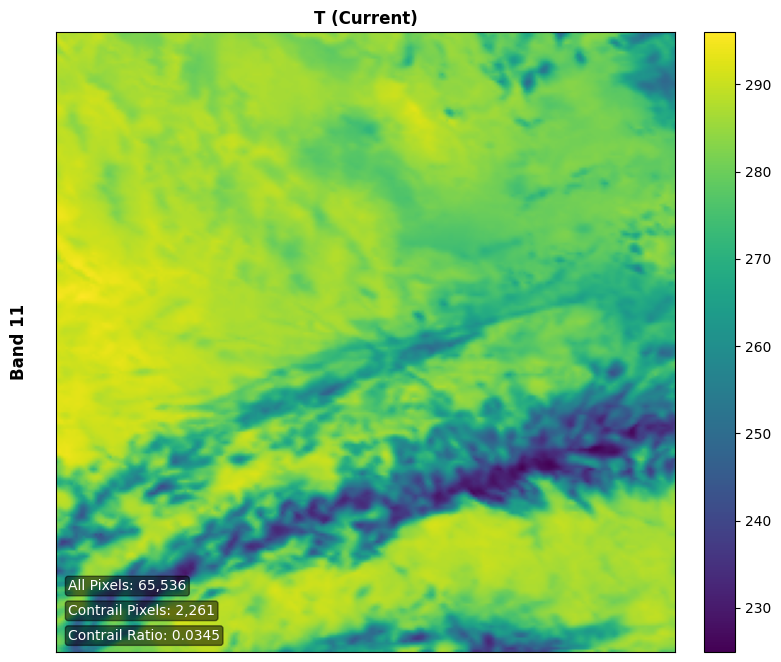

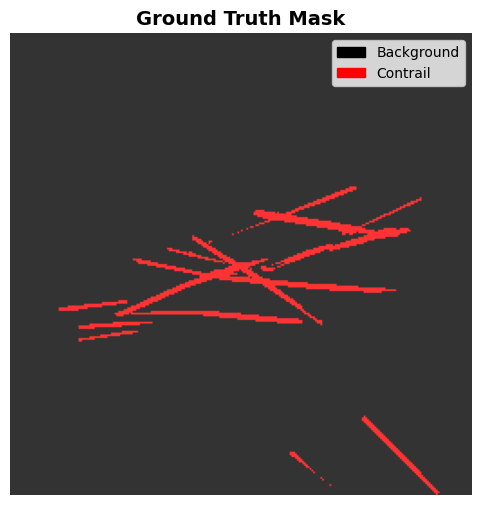

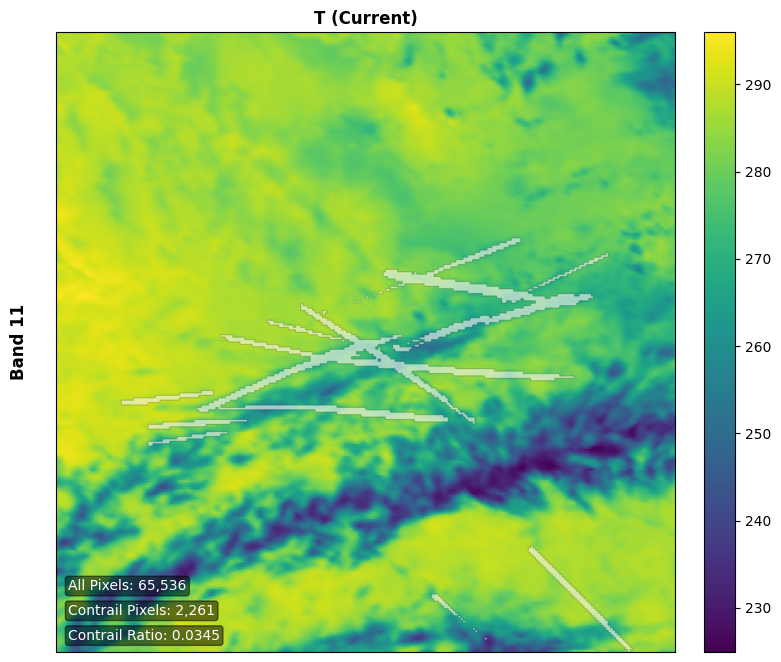

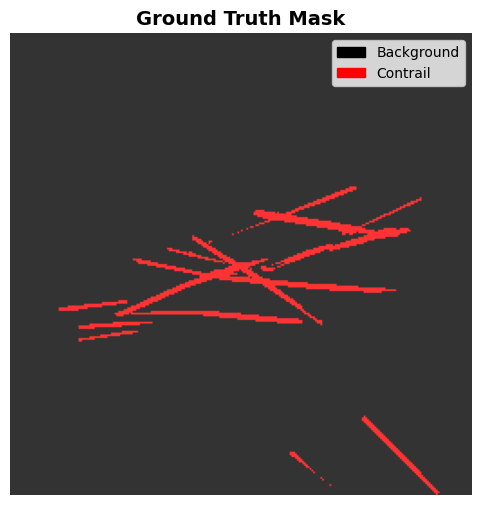

In [58]:
# Prepare data dictionary
bands_data = {
    'inner_band_08': inner_band_08,
    'inner_band_09': inner_band_09,
    'inner_band_10': inner_band_10,
    'inner_band_11': inner_band_11,
    'inner_band_12': inner_band_12,
    'inner_band_13': inner_band_13,
    'inner_band_14': inner_band_14,
    'inner_band_15': inner_band_15,
    'inner_band_16': inner_band_16,
}

# 1. Visualize all band data (current time)
print("=== All Band Data Visualization ===")
demo_path = basic_dir_paths[25]
visualize_contrail_data(
    sample_path=demo_path,
    bands_to_visualize=["11"],
    time_steps=4,
    overlay_mask=False,
    figsize_base=(8, 7),
)
visualize_contrail_data(
    sample_path=demo_path,
    bands_to_visualize=["11"],
    time_steps=4,
    overlay_mask=True,
    figsize_base=(8, 7),
)